# SSH-sst feedback : 

Computes sea surface height anomalies (SSHA; used as a proxy for subsurface temperature) regressed onto sea surface temperature anomalies (SSTA) both in the eastern equatorial Pacific (horizontal Niño3 average).

#### Reference observations:
TropFlux and AVISO 1993-2018 (main)

SSH: JPL-MEASURES 1993-2021, CSIRO-SSH 1993-2019, GODAS 1980-2023, ORAS5 1958-2022, SODA3.4.2 1979-2018
SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [2]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [3]:
model_ssh_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_ssh_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

#tos
model_tos = {"ACCESS-ESM1-5": 
    model_ssh_datasets["ACCESS-ESM1-5"].copy(short_name='tos')}



obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19930101/20190101",
    tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}
obs_zos_datasets = {
 "CMEMS": 
     Dataset(
     short_name='zos',
     dataset='CMEMS',
     mip="Omon",
     project='OBS6',
     type='sat',
     timerange="19930101/20190101",
     tier=2)
}

In [4]:
model_ssh_datasets = {name: dataset.load() for name, dataset in model_ssh_datasets.items()}
model_tos = {name: dataset.load() for name, dataset in model_tos.items()}

obs_tos_datasets = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
obs_zos_datasets = {name: dataset.load() for name, dataset in obs_zos_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/scipy/linalg/_basic.py:1486: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/scipy/linalg/_basic.py:1486: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [6]:
def ssh_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = mask_landsea(cube, mask_out="land") #irregular
    cube = convert_units(cube, units="cm")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    
    # cube = area_statistics(cube,operator='mean')
    return cube


def tos_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    return cube   

In [10]:
model_ssh_prep = {name: ssh_east(dataset) for name, dataset in model_ssh_datasets.items()}
model_tos_prep = {name: tos_east(dataset) for name, dataset in model_tos.items()}

obs_tos_prep = {name: tos_east(dataset) for name, dataset in obs_tos_datasets.items()}
obs_zos_prep = {name: ssh_east(dataset) for name, dataset in obs_zos_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along first dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2158: IrisVagueMetadataWarning: Collapsin

## Calculate Linear regression

In [7]:

def linreg_1d(a_cube, b_cube):
    print("cube shapes:", a_cube.shape, b_cube.shape)
    B_data = b_cube.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, a_cube.data, rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept


# Diagnostic Level 1

cube shapes: (432,) (432,)
0.020124065 -3.9497285e-09
cube shapes: (312,) (312,)
(432,) (432,)
degC cm
(312,) (312,)


Text(0.99, 0.03, 'metric: 73.75%')

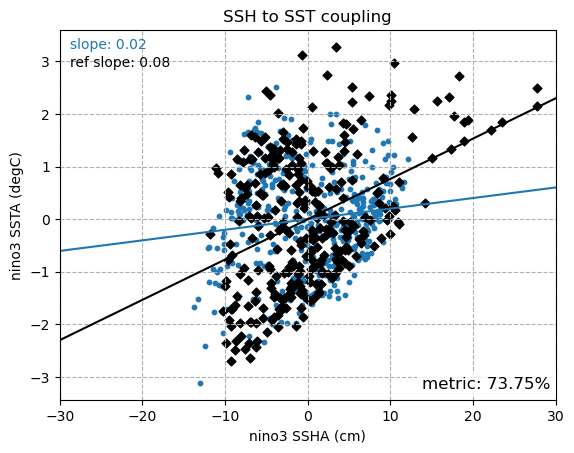

In [13]:

xseq = np.linspace(-40, 40, num=100)

slope, intcpt = linreg_1d(model_tos_prep["ACCESS-ESM1-5"], model_ssh_prep["ACCESS-ESM1-5"])
plt.plot(xseq, intcpt+slope*xseq)
print(slope, intcpt)
mod_slope = slope

slope, intcpt = linreg_1d(obs_tos_prep["HadISST"], obs_zos_prep["CMEMS"])
plt.plot(xseq, intcpt+slope*xseq, color='black')
metric_val = abs((mod_slope-slope)/slope)*100

print(model_tos_prep["ACCESS-ESM1-5"].shape, model_ssh_prep["ACCESS-ESM1-5"].shape) #scatter plot
print(model_tos_prep["ACCESS-ESM1-5"].units, model_ssh_prep["ACCESS-ESM1-5"].units)
plt.scatter(model_ssh_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data, s=10)

print(obs_tos_prep["HadISST"].shape, obs_zos_prep["CMEMS"].shape)
plt.scatter(obs_zos_prep["CMEMS"].data, obs_tos_prep["HadISST"].data, s=20, c='black', marker='D')
plt.xlim(-30,30)
yunit = model_tos_prep["ACCESS-ESM1-5"].units 
xunit = model_ssh_prep["ACCESS-ESM1-5"].units

plt.title('SSH to SST coupling')
plt.ylabel(f'nino3 SSTA ({yunit})')
plt.xlabel(f'nino3 SSHA ({xunit})')
plt.grid(linestyle='--')

## text slope
plt.text(0.02, 0.95, f'slope: {mod_slope:.2f} ', fontsize=10, ha='left', color='C0',
         transform=plt.gca().transAxes)
plt.text(0.02, 0.9, f'ref slope: {slope:.2f} ', fontsize=10, ha='left', color='k',
         transform=plt.gca().transAxes)

plt.text(0.99, 0.03, f'metric: {metric_val:.2f}%', fontsize=12, ha='right',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# print(metric_val)

# Diagnostic Level 2

In [17]:
import pandas as pd

def linreg_df(var_a, var_b):
    B_data = np.array(var_b)
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, np.array(var_a), rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

def plt_lvl2_subplot(y_cube, x_cube, dataset_label):
    
    df = pd.DataFrame({'var_a':y_cube.data, 'var_b':x_cube.data})
    slopes = []
    print(dataset_label, 'shape: ', df.shape)
    plt.scatter(x_cube.data, y_cube.data, c='k', s=10)
    xseq = np.linspace(-40, 40, num=50)
    slope, intcpt = linreg_df(df['var_a'], df['var_b'])
    plt.plot(xseq, intcpt+slope*xseq, c='black')
    slopes.append(slope)
    
    xseq = np.linspace(-40, 0, num=50) #
    slope, intcpt = linreg_df(df.loc[df['var_b']<0, 'var_a'], df.loc[df['var_b']<0, 'var_b'])
    
    plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
    slopes.append(slope)
    
    xseq = np.linspace(0, 40, num=50)
    slope, intcpt = linreg_df(df.loc[df['var_b']>0, 'var_a'], df.loc[df['var_b']>0, 'var_b'])
    plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
    slopes.append(slope)

    plt.title(dataset_label)
    plt_settings(slopes)

def plt_settings(slopes):
    plt.xlim(-40,40)
    plt.xticks(np.arange(-40,50,20))
    plt.ylim(-6,6)
    plt.yticks(np.arange(-6,7,3))
    plt.grid(linestyle='--')
    plt.xlabel(f'nino3 SSHA (cm)')
    plt.ylabel(f'nino3 SSTA (°C)')
    print(slopes)
    plt.text(0.02, 0.85, f'slope(all): {slopes[0]:.2f}\nslope(x<0): {slopes[1]:.2f}\nslope(x>0): {slopes[2]:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ACCESS-ESM1-5 shape:  (432, 2)
[0.020124065, 0.04440729, 0.10493521]
HadISST_CMEMS shape:  (312, 2)
[0.076674156, 0.0707969, 0.104506664]


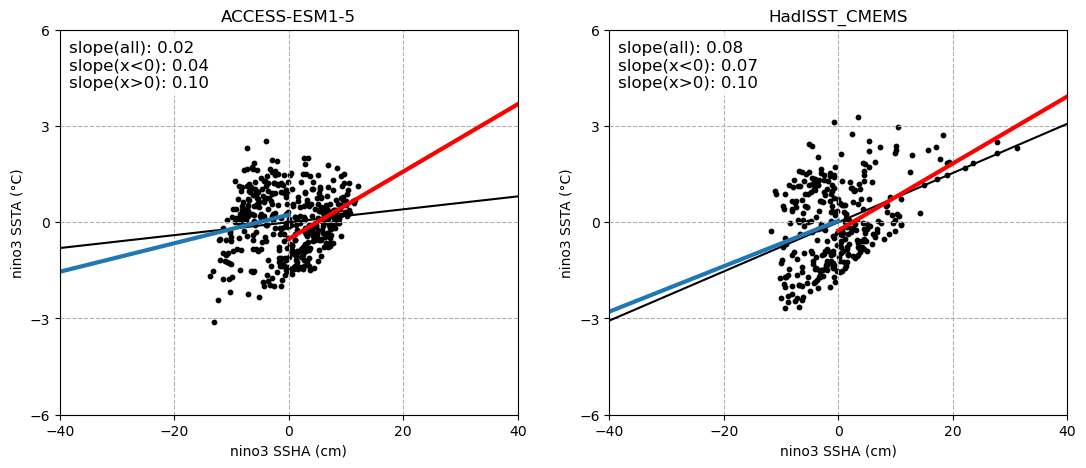

In [20]:
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(121)

plt_lvl2_subplot(model_tos_prep["ACCESS-ESM1-5"],model_ssh_prep["ACCESS-ESM1-5"], 'ACCESS-ESM1-5')

ax = plt.subplot(122)
plt_lvl2_subplot(obs_tos_prep["HadISST"], obs_zos_prep["CMEMS"], 'HadISST_CMEMS')

Figure 2: scatterplot of sea surface height anomalies (SSHA) and sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the SSH-to-SST coupling (usually shows no nonlinearity in both reference and model). The black, red and blue lines and numbers show respectively linear regression computed for all SSHA, SSHA>0 and SSHA<0, the left and right scatterplots show respectively the reference and the model.

## Dive down level 3

In [22]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold

def ssh_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="cm")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **region)
    cube = area_statistics(cube,operator='mean')    
    return cube

def sst_meri_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    return cube 

In [23]:
model_zos = {name: ssh_eqp(dataset) for name, dataset in model_ssh_datasets.items()}
model_tos = {name: sst_meri_eqp(dataset) for name, dataset in model_tos.items()}

obs_zos = {name: ssh_eqp(dataset) for name, dataset in obs_zos_datasets.items()}
obs_tos = {name: sst_meri_eqp(dataset) for name, dataset in obs_tos_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'month_number', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'month_number'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid oper

In [27]:
def lin_regress_matrix(cubeA, cubeBsst):
    
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # masked threshold cube (time,) 

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    
    print('least squares data shapes ',B_with_intercept.shape, A_data.shape)
    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(coefs[0], long_name='regression SSTA,TAUXA',
                                 dim_coords_and_dims=[(cubeA.coord('longitude'), 0)])

    return result_cube


def feedback_nonlin(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)
    print(sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)

    below0 = iris.Constraint(sea_surface_height_above_geoid=lambda cell: cell < 0) #change variable
    above0 = iris.Constraint(sea_surface_height_above_geoid=lambda cell: cell > 0)
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = lin_regress_matrix(xbelow0, ssta_neg)
    posreg_cube = lin_regress_matrix(xabove0, ssta_pos)

    return outreg_cube, posreg_cube

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'
        

sea_surface_height_above_geoid Sea Surface Height Above Geoid zos cm
least squares data shapes  (201, 2) (201, 91)
least squares data shapes  (231, 2) (231, 91)
sea_surface_height_above_geoid Sea Surface Height Above Geoid zos cm
least squares data shapes  (169, 2) (169, 91)
least squares data shapes  (143, 2) (143, 91)
least squares data shapes  (432, 2) (432, 91)
least squares data shapes  (312, 2) (312, 91)


Text(0.5, 1.0, 'Thermocline feedback')

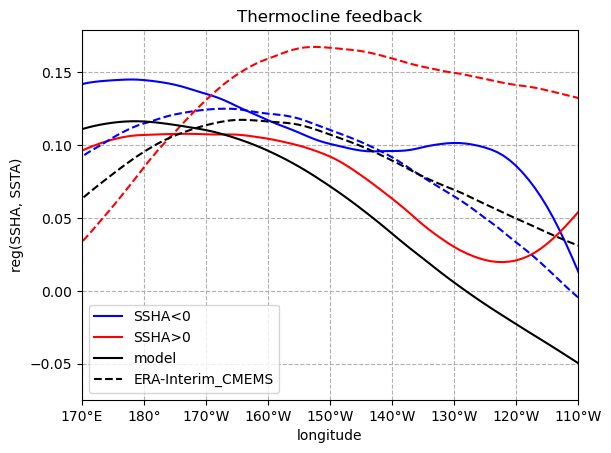

In [28]:
neg, pos = feedback_nonlin(model_zos["ACCESS-ESM1-5"], model_tos["ACCESS-ESM1-5"])

qplt.plot(neg, color='blue', linestyle='solid', label='SSHA<0')
qplt.plot(pos, color='red', linestyle='solid', label='SSHA>0')

neg, pos = feedback_nonlin(obs_zos["CMEMS"], obs_tos["HadISST"])
qplt.plot(neg, color='blue', linestyle='--')
qplt.plot(pos, color='red', linestyle='--')

cb = lin_regress_matrix(model_tos["ACCESS-ESM1-5"], model_zos["ACCESS-ESM1-5"])
        
qplt.plot(cb, color='black', linestyle='solid', label='model')

cb2 = lin_regress_matrix(obs_tos["HadISST"], obs_zos["CMEMS"])
qplt.plot(cb2, color='black', linestyle='--', label='ERA-Interim_CMEMS')

plt.xlim(170, 250)
plt.xlabel('longitude')
plt.ylabel('reg(SSHA, SSTA)')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
plt.legend()
plt.title("Thermocline feedback")

Figure 3: spatial structure of sea surface temperature anomalies (SSTA) regressed onto sea surface height anomalies (SSHA) both in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average), showing the possible nonlinearity in the strength of the SSH-to-SST coupling (usually shows too strong coupling in the central and eastern equatorial Pacific, no nonlinearity in both reference and model; here the model shows a nonlinearity in the far eastern equatorial Pacific). The black, red and blue lines and numbers show respectively linear regression computed for all SSHA, SSHA>0 and SSHA<0, the dashed and solid curves show respectively the reference and the model.